In [19]:
pip install numpy matplotlib scikit-learn tensorflow astropy tensorflow_addons opencv-python

  Using cached opencv_python-4.11.0.86-cp310-cp310-macosx_12_0_arm64.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
# additional imports for metrics and plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from astropy.visualization import ZScaleInterval


In [2]:
import tensorflow as tf

In [3]:

# Load training samples data
base_dir = "."
input_file = os.path.join(base_dir, "exromana_training_samples.npy")
data = np.load(input_file, allow_pickle=True).item()

tp_samples = data.get("TP", [])
fp_samples = data.get("FP", [])



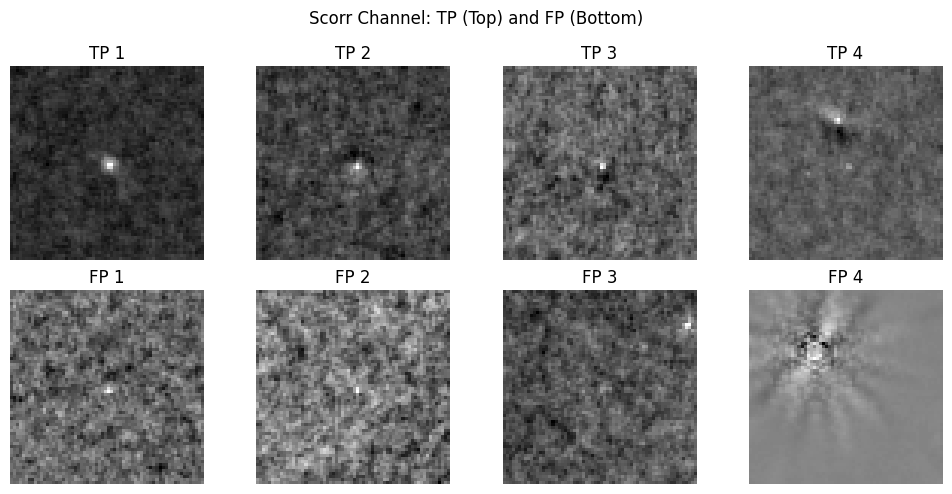

In [4]:

# Visualize 4 TP and 4 FP images
plt.figure(figsize=(10, 5))

# Plot 4 TP images
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(tp_samples[i]["sample"][..., 3], cmap="gray")
    plt.title("TP {}".format(i+1))
    plt.axis("off")

# Plot 4 FP images
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.imshow(fp_samples[i]["sample"][..., 3], cmap="gray")
    plt.title("FP {}".format(i+1))
    plt.axis("off")

plt.suptitle("Scorr Channel: TP (Top) and FP (Bottom)")
plt.tight_layout()
plt.show()


In [5]:

# Extract the fourth layer (scorr channel) from sample["sample"] (64x64x4 array)
samples = []
labels = []
for sample in tp_samples:
    samples.append(sample["sample"][..., 3])
    labels.append(1)

for sample in fp_samples:
    samples.append(sample["sample"][..., 3])
    labels.append(0)

X = np.array(samples)
y = np.array(labels)

# Ensure images have a channel dimension (now grayscale images of the scorr layer)
if len(X.shape) == 3:  # shape (N, height, width)
    X = np.expand_dims(X, -1)

# Normalize the data using ZScale: for each sample compute limits and scale to [0,255]
zscale = ZScaleInterval()
X_z = np.empty_like(X, dtype=np.float32)
for i in range(X.shape[0]):
    # Remove channel dimension for zscale calculation
    img = X[i, ..., 0]
    vmin, vmax = zscale.get_limits(img)
    # Linear scaling to [0,255]
    scaled = (img - vmin) * (255.0 / (vmax - vmin))
    X_z[i, ..., 0] = np.clip(scaled, 0, 255)
X = X_z.astype(np.uint8)

print("After ZScale normalization - min:", np.min(X), "max:", np.max(X))

# Split data: first extract test set (15%), then split remaining into training and validation.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
val_ratio = 0.15 / 0.85  # relative validation size from remaining data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp)


After ZScale normalization - min: 0 max: 255


/var/folders/by/k_8nsxzs4p75xm0rpv7k951c0000gn/T/ipykernel_7581/122674774.py:29: RuntimeWarning: invalid value encountered in cast
  X = X_z.astype(np.uint8)


In [19]:
# Improved CNN architecture
input_shape = X_train.shape[1:]
weight_decay = 1e-2

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1,  # downsample here
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
#                            input_shape=input_shape),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.Conv2D(128, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), padding='same', strides=2,  # downsample here
                           kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                           input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=2,
                           kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=2,
                           kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#     # Downsample 1
#     tf.keras.layers.Conv2D(16, (3, 3), padding='same', strides=2,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
#                            input_shape=input_shape),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     # Extra conv layers with stride 1 (no downsampling)
#     tf.keras.layers.Conv2D(16, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     # Downsample 2
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=2,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     # Extra conv layers with stride 1
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     # Downsample 3
#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=2,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     # Extra conv layer with stride 1
#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model = tf.keras.models.Sequential([
#     # Downsample 1
#     tf.keras.layers.Conv2D(16, (3, 3), padding='same', strides=2,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
#                            input_shape=input_shape),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.2),

#     # Extra conv layers with stride 1 (no downsampling)
#     tf.keras.layers.Conv2D(16, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.2),

#     # Downsample 2
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=2,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     # Extra conv layers with stride 1
#     tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     # Downsample 3
#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=2,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.4),

#     # Extra conv layer with stride 1
#     tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=1,
#                            kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.4),

#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])




optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=weight_decay)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

num_epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=1,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])



Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,857 (101.00 KB)

 Trainable params: 25,633 (100.13 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6601 - loss: 1.3416 - val_accuracy: 0.6410 - val_loss: 0.8771
Epoch 2/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6556 - loss: 0.8321 - val_accuracy: 0.6410 - val_loss: 0.7604
Epoch 3/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6522 - loss: 0.7334 - val_accuracy: 0.6667 - val_loss: 0.7214
Epoch 4/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6763 - loss: 0.6777 - val_accuracy: 0.6681 - val_loss: 0.6580
Epoch 5/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6619 - loss: 0.6498 - val_accuracy: 0.6538 - val_loss: 0.6383
Epoch 6/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6684 - loss: 0.6291 - val_accuracy: 0.6496 - val_loss: 0.6463
Epoch 7/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6609 - loss: 0.6260 - val_accuracy: 0.6567 - val_loss: 0.8590
Epoch 8/100
3273/3273 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6638 - loss: 0

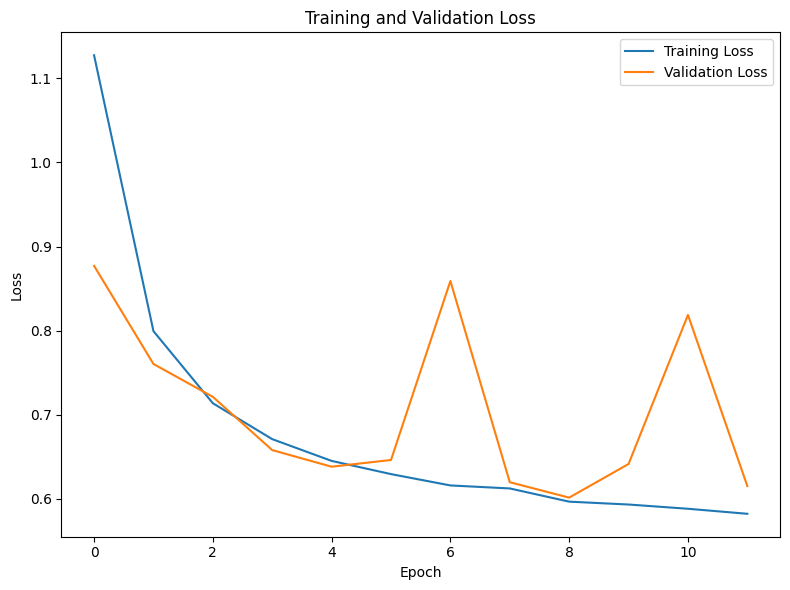

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6495 - loss: 0.5923
Test Accuracy: 0.6709401607513428
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
[[438  30]
 [201  33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       468
           1       0.52      0.14      0.22       234

    accuracy                           0.67       702
   macro avg       0.60      0.54      0.51       702
weighted avg       0.63      0.67      0.60       702



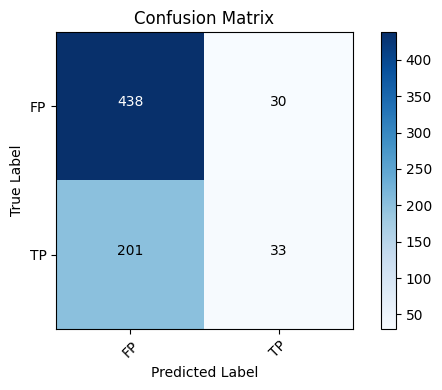

In [21]:

# Display training and validation losses.
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(os.path.join(base_dir, "validation_loss_{num_epochs}.png"))
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Compute predictions, confusion matrix, and classification report.
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix.
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["FP", "TP"], rotation=45)
plt.yticks(tick_marks, ["FP", "TP"])

# Annotate each cell with its value.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max()/2. else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(base_dir, "validation_CM_{num_epochs}.png"))
plt.tight_layout()
plt.show()


# Improvements

Early Stopping
Added an early stopping callback to monitor validation loss and stop training when the model stops improving. This prevents overfitting and saves training time by restoring the best model weights.

Weight Decay (L2 Regularization)
Incorporated weight decay in convolutional and dense layers to penalize large weights, encouraging simpler models that generalize better.

AdamW Optimizer
Used the AdamW optimizer, which decouples weight decay from the gradient update step. Unlike standard Adam with L2 regularization, AdamW applies weight decay directly to weights, leading to better regularization and improved convergence behavior.

Architecture Sweeps
Explored various network designs including:

    - Number of layers and filters

    - Kernel sizes (3x3 vs 7x7)

    - Stride settings for downsampling

    - Adding more convolutional layers with stride=1
These sweeps helped find a balance between model capacity and overfitting risk.

Extended Training Epochs
Allowed training for more epochs (up to 20) with early stopping to enable the model to fully learn without overfitting.

Data Visualization
Visualized sample inputs from both positive and negative classes to ensure data quality and understand class characteristics better.

LeakyReLU Activation
Replaced standard ReLU with LeakyReLU activations, which help avoid “dead neurons” by allowing a small gradient when inputs are negative, leading to more stable and effective training.

Dropout Regularization Throughout
Added dropout layers after each activation in the convolutional blocks with increasing dropout rates deeper in the network. This helps prevent overfitting by randomly dropping features during training.

Normalization (BatchNormalization)
Used batch normalization after each convolutional layer to stabilize and accelerate training.